In [1]:
import os
import pickle
from math import pi

import numpy as np


import pandas as pd
from pyomo.environ import *


class RawData:
    "Load raw data to be used in model"
    
    def __init__(self, data_dir, scenarios_dir, seed=10):
        
        # Paths to directories
        # --------------------
        self.data_dir = data_dir
        
        
        # Network data
        # ------------
        # Nodes
        self.df_n = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_nodes.csv'), index_col='NODE_ID')

        # AC edges
        self.df_e = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_edges.csv'), index_col='LINE_ID')

        # HVDC links
        self.df_hvdc_links = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_hvdc_links.csv'), index_col='HVDC_LINK_ID')

        # AC interconnector links
        self.df_ac_i_links = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_ac_interconnector_links.csv'), index_col='INTERCONNECTOR_ID')

        # AC interconnector flow limits
        self.df_ac_i_limits = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_ac_interconnector_flow_limits.csv'), index_col='INTERCONNECTOR_ID')


        # Generators
        # ----------       
        # Generating unit information
        self.df_g = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'generators', 'generators.csv'), index_col='DUID', dtype={'NODE': int})
        
        # Perturb short-run marginal costs (SRMCs) so all unique 
        # (add uniformly distributed random number between 0 and 2 to each SRMC. Set seed so this randomness
        # can be reproduced)
        np.random.seed(seed)
        self.df_g['SRMC_2016-17'] = self.df_g['SRMC_2016-17'] + np.random.uniform(0, 2, self.df_g.shape[0])
        
        
        # Load scenario data
        # ------------------
        with open(os.path.join(scenarios_dir, 'weekly_scenarios.pickle'), 'rb') as f:
            self.df_scenarios = pickle.load(f)
        

class OrganiseData(RawData):
    "Organise data to be used in mathematical program"
    
    def __init__(self, data_dir, scenarios_dir):
        # Load model data
        super().__init__(data_dir, scenarios_dir)
        
        
    def get_admittance_matrix(self):
        "Construct admittance matrix for network"

        # Initialise dataframe
        df_Y = pd.DataFrame(data=0j, index=self.df_n.index, columns=self.df_n.index)

        # Off-diagonal elements
        for index, row in self.df_e.iterrows():
            fn, tn = row['FROM_NODE'], row['TO_NODE']
            df_Y.loc[fn, tn] += - (1 / (row['R_PU'] + 1j * row['X_PU'])) * row['NUM_LINES']
            df_Y.loc[tn, fn] += - (1 / (row['R_PU'] + 1j * row['X_PU'])) * row['NUM_LINES']

        # Diagonal elements
        for i in self.df_n.index:
            df_Y.loc[i, i] = - df_Y.loc[i, :].sum()

        # Add shunt susceptance to diagonal elements
        for index, row in self.df_e.iterrows():
            fn, tn = row['FROM_NODE'], row['TO_NODE']
            df_Y.loc[fn, fn] += (row['B_PU'] / 2) * row['NUM_LINES']
            df_Y.loc[tn, tn] += (row['B_PU'] / 2) * row['NUM_LINES']

        return df_Y
    
    
    def get_HVDC_incidence_matrix(self):
        "Incidence matrix for HVDC links"
        
        # Incidence matrix for HVDC links
        df = pd.DataFrame(index=self.df_n.index, columns=self.df_hvdc_links.index, data=0)

        for index, row in self.df_hvdc_links.iterrows():
            # From nodes assigned a value of 1
            df.loc[row['FROM_NODE'], index] = 1

            # To nodes assigned a value of -1
            df.loc[row['TO_NODE'], index] = -1
        
        return df
    
    
    def get_all_ac_edges(self):
        "Tuples defining from and to nodes for all AC edges (forward and reverse)"
        
        # Set of all AC edges
        edge_set = set()
        
        # Loop through edges, add forward and reverse direction indice tuples to set
        for index, row in self.df_e.iterrows():
            edge_set.add((row['FROM_NODE'], row['TO_NODE']))
            edge_set.add((row['TO_NODE'], row['FROM_NODE']))
        
        return edge_set
    
    
    def get_network_graph(self):
        "Graph containing connections between all network nodes"
        network_graph = {n: set() for n in self.df_n.index}

        for index, row in self.df_e.iterrows():
            network_graph[row['FROM_NODE']].add(row['TO_NODE'])
            network_graph[row['TO_NODE']].add(row['FROM_NODE'])
        
        return network_graph
    
    
    def get_all_dispatchable_fossil_generator_duids(self):
        "Fossil dispatch generator DUIDs"
        
        # Filter - keeping only fossil and scheduled generators
        mask = (self.df_g['FUEL_CAT'] == 'Fossil') & (self.df_g['SCHEDULE_TYPE'] == 'SCHEDULED')
        
        return self.df_g[mask].index    
       
    
    def get_reference_nodes(self):
        "Get reference node IDs"
        
        # Filter Regional Reference Nodes (RRNs) in Tasmania and Victoria.
        mask = (self.df_n['RRN'] == 1) & (self.df_n['NEM_REGION'].isin(['TAS1', 'VIC1']))
        reference_node_ids = self.df_n[mask].index
        
        return reference_node_ids
    
       
    def get_generator_node_map(self, generators):
        "Get set of generators connected to each node"
        
        generator_node_map = (self.df_g.reindex(index=generators)
                              .reset_index()
                              .rename(columns={'OMEGA_G': 'DUID'})
                              .groupby('NODE').agg(lambda x: set(x))['DUID']
                              .reindex(self.df_n.index, fill_value=set()))
        
        return generator_node_map
    
    
    def get_ac_interconnector_summary(self):
        "Summarise aggregate flow limit information for AC interconnectors"

        # Create dicitionary containing collections of AC branches for which interconnectors are defined. Create
        # These collections for both forward and reverse directions.
        interconnector_limits = {}

        for index, row in self.df_ac_i_limits.iterrows():
            # Forward limit
            interconnector_limits[index+'-FORWARD'] = {'FROM_REGION': row['FROM_REGION'], 'TO_REGION': row['TO_REGION'], 'LIMIT': row['FORWARD_LIMIT_MW']}

            # Reverse limit
            interconnector_limits[index+'-REVERSE'] = {'FROM_REGION': row['TO_REGION'], 'TO_REGION': row['FROM_REGION'], 'LIMIT': row['REVERSE_LIMIT_MW']}

        # Convert to DataFrame
        df_interconnector_limits = pd.DataFrame(interconnector_limits).T

        # Find all branches that consitute each interconnector - order is important. 
        # First element is 'from' node, second is 'to node
        branch_collections = {b: {'branches': list()} for b in df_interconnector_limits.index}

        for index, row in self.df_ac_i_links.iterrows():
            # For a given branch, find the interconnector index to which it belongs. This will either be the forward or
            # reverse direction as defined in the interconnector links DataFrame. If the forward direction, 'FROM_REGION'
            # will match between DataFrames, else it indicates the link is in the reverse direction.

            # Assign branch to forward interconnector limit ID
            mask_forward = (df_interconnector_limits.index.str.contains(index) 
                      & (df_interconnector_limits['FROM_REGION'] == row['FROM_REGION']) 
                      & (df_interconnector_limits['TO_REGION'] == row['TO_REGION']))

            # Interconnector ID corresponding to branch 
            branch_index_forward = df_interconnector_limits.loc[mask_forward].index[0]

            # Add branch tuple to branch collection
            branch_collections[branch_index_forward]['branches'].append((row['FROM_NODE'], row['TO_NODE']))

            # Assign branch to reverse interconnector limit ID
            mask_reverse = (df_interconnector_limits.index.str.contains(index) 
                            & (df_interconnector_limits['FROM_REGION'] == row['TO_REGION']) 
                            & (df_interconnector_limits['TO_REGION'] == row['FROM_REGION']))

            # Interconnector ID corresponding to branch 
            branch_index_reverse = df_interconnector_limits.loc[mask_reverse].index[0]

            # Add branch tuple to branch collection
            branch_collections[branch_index_reverse]['branches'].append((row['TO_NODE'], row['FROM_NODE']))

        # Append branch collections to interconnector limits DataFrame
        df_interconnector_limits['branches'] = pd.DataFrame(branch_collections).T['branches']
        
        return df_interconnector_limits

    
class DCOPFModel(OrganiseData):
    "Create DCOPF model"
    
    def __init__(self, data_dir, scenarios_dir):
        # Load model data
        super().__init__(data_dir, scenarios_dir)
        
        # Initialise DCOPF model
        self.model = self.create_model()
        
        
        # Setup solver
        # ------------
        # Import dual variables
        self.model.dual = Suffix(direction=Suffix.IMPORT)
        
        # Specify solver to be used and output format
        self.opt = SolverFactory('gurobi', solver_io='mps')
        
        
        # Parameters used for different scenarios
        # ---------------------------------------
        # Week index
        self.week_index = None
        
        # Scenario index
        self.scenario_index = None
        
        
    def create_model(self):
        "Create model object"

        # Initialise model
        model = ConcreteModel()

        # Sets
        # ----   
        # Nodes
        model.OMEGA_N = Set(initialize=self.df_n.index)

        # Generators
        model.OMEGA_G = Set(initialize=self.get_all_dispatchable_fossil_generator_duids())

        # AC edges
        ac_edges = self.get_all_ac_edges()
        model.OMEGA_NM = Set(initialize=ac_edges)

        # Sets of branches for which aggregate AC interconnector limits are defined
        ac_limits = self.get_ac_interconnector_summary()
        model.OMEGA_J = Set(initialize=ac_limits.index)

        # HVDC links
        model.OMEGA_H = Set(initialize=self.df_hvdc_links.index)


        # Parameters
        # ----------
        # System base power
        model.BASE_POWER = Param(initialize=100)

        # Emissions intensity baseline
        model.PHI = Param(initialize=0, mutable=True)

        # Permit price
        model.TAU = Param(initialize=0, mutable=True)

        # Generator emissions intensities
        def E_RULE(model, g):
            return float(self.df_g.loc[g, 'EMISSIONS'])
        model.E = Param(model.OMEGA_G, rule=E_RULE)

        # Admittance matrix
        admittance_matrix = self.get_admittance_matrix()
        def B_RULE(model, n, m):
            return float(np.imag(admittance_matrix.loc[n, m]))
        model.B = Param(model.OMEGA_NM, rule=B_RULE)

        # Reference nodes
        reference_nodes = self.get_reference_nodes()
        def S_RULE(model, n):
            if n in reference_nodes:
                return 1
            else:
                return 0
        model.S = Param(model.OMEGA_N, rule=S_RULE)

        # Generator short-run marginal costs
        def C_RULE(model, g):
            marginal_cost = float(self.df_g.loc[g, 'SRMC_2016-17'])
            return marginal_cost / model.BASE_POWER
        model.C = Param(model.OMEGA_G, rule=C_RULE)

        # Demand
        model.D = Param(model.OMEGA_N, initialize=0, mutable=True)

        # Max voltage angle difference between connected nodes
        model.THETA_DELTA = Param(initialize=float(pi / 2))

        # HVDC incidence matrix
        hvdc_incidence_matrix = self.get_HVDC_incidence_matrix()
        def K_RULE(model, n, h):
            return float(hvdc_incidence_matrix.loc[n, h])
        model.K = Param(model.OMEGA_N, model.OMEGA_H, rule=K_RULE)    

        # Aggregate AC interconnector flow limits
        def F_RULE(model, j):
            power_flow_limit = float(ac_limits.loc[j, 'LIMIT'])
            return power_flow_limit / model.BASE_POWER
        model.F = Param(model.OMEGA_J, rule=F_RULE)

        # Fixed power injections
        model.R = Param(model.OMEGA_N, initialize=0, mutable=True)
        
        # Maximum power output
        def REGISTERED_CAPACITY_RULE(model, g):
            registered_capacity = float(self.df_g.loc[g, 'REG_CAP'])
            return registered_capacity / model.BASE_POWER
        model.REGISTERED_CAPACITY = Param(model.OMEGA_G, rule=REGISTERED_CAPACITY_RULE)

        # Emissions intensity shock indicator parameter. Used to scale original emissions intensities.
        model.EMISSIONS_INTENSITY_SHOCK_FACTOR = Param(model.OMEGA_G, initialize=1, mutable=True)
        
        # Duration of each scenario (will be updated each time model is run. Useful when computing
        # total emissions / total scheme revenue etc.)
        model.SCENARIO_DURATION = Param(initialize=0, mutable=True)
        
        
        # Variables
        # ---------
        # Generator output (constrained to non-negative values)
        model.p = Var(model.OMEGA_G, within=NonNegativeReals)

        # HVDC flows
        def P_H_RULE(model, h):
            forward_flow_limit = float(self.df_hvdc_links.loc[h, 'FORWARD_LIMIT_MW'])
            reverse_flow_limit = float(self.df_hvdc_links.loc[h, 'REVERSE_LIMIT_MW'])
            return (- reverse_flow_limit / model.BASE_POWER, forward_flow_limit / model.BASE_POWER)
        model.p_H = Var(model.OMEGA_H, bounds=P_H_RULE)

        # Node voltage angles
        model.theta = Var(model.OMEGA_N)


        # Constraints
        # -----------
        # Power balance
        generator_node_map = self.get_generator_node_map(model.OMEGA_G)
        network_graph = self.get_network_graph()
        def POWER_BALANCE_RULE(model, n):
            return (- model.D[n] 
                    + model.R[n]
                    + sum(model.p[g] for g in generator_node_map[n]) 
                    - sum(model.B[n, m] * (model.theta[n] - model.theta[m]) for m in network_graph[n]) 
                    - sum(model.K[n, h] * model.p_H[h] for h in model.OMEGA_H) == 0)
        model.POWER_BALANCE = Constraint(model.OMEGA_N, rule=POWER_BALANCE_RULE)
        
        # Max power output
        def P_MAX_RULE(model, g):
            return model.p[g] <= model.REGISTERED_CAPACITY[g]
        model.P_MAX = Constraint(model.OMEGA_G, rule=P_MAX_RULE)

        # Reference angle
        def REFERENCE_ANGLE_RULE(model, n):
            if model.S[n] == 1:
                return model.theta[n] == 0
            else:
                return Constraint.Skip
        model.REFERENCE_ANGLE = Constraint(model.OMEGA_N, rule=REFERENCE_ANGLE_RULE)

        # Voltage angle difference constraint
        def VOLTAGE_ANGLE_DIFFERENCE_RULE(model, n, m):
            return model.theta[n] - model.theta[m] - model.THETA_DELTA <= 0
        model.VOLTAGE_ANGLE_DIFFERENCE = Constraint(model.OMEGA_NM, rule=VOLTAGE_ANGLE_DIFFERENCE_RULE)

        # AC interconnector flow constraints
        def AC_FLOW_RULE(model, j):
            return sum(model.B[n, m] * (model.theta[n] - model.theta[m]) for n, m in ac_limits.loc[j, 'branches'])
        model.AC_FLOW = Expression(model.OMEGA_J, rule=AC_FLOW_RULE)

        def AC_POWER_FLOW_LIMIT_RULE(model, j):
            return model.AC_FLOW[j] - model.F[j] <= 0
        model.AC_POWER_FLOW_LIMIT = Constraint(model.OMEGA_J, rule=AC_POWER_FLOW_LIMIT_RULE)

        
        # Expressions
        # -----------
        # Effective emissions intensity (original emissions intensity x scaling factor)
        def E_HAT_RULE(model, g):
            return model.E[g] * model.EMISSIONS_INTENSITY_SHOCK_FACTOR[g]
        model.E_HAT = Expression(model.OMEGA_G, rule=E_HAT_RULE)
        
        # Total emissions [tCO2]
        model.TOTAL_EMISSIONS = Expression(expr=sum(model.p[g] * model.BASE_POWER * model.E_HAT[g] * model.SCENARIO_DURATION for g in model.OMEGA_G))
        
        # Total energy demand [MWh]
        model.TOTAL_ENERGY_DEMAND = Expression(expr=sum(model.D[n] * model.BASE_POWER * model.SCENARIO_DURATION for n in model.OMEGA_N))
        
        # Total energy output from regulated generators [MWh]
        model.TOTAL_REGULATED_GENERATOR_ENERGY = Expression(expr=sum(model.p[g] * model.BASE_POWER * model.SCENARIO_DURATION for g in model.OMEGA_G))
        
        # Average emissions intensity of regulated generators [tCO2/MWh]
        model.AVERAGE_EMISSIONS_INTENSITY_REGULATED_GENERATORS = Expression(expr=model.TOTAL_EMISSIONS / model.TOTAL_REGULATED_GENERATOR_ENERGY)
        
        # Average emissions intensity of system [tCO2/MWh]
        model.AVERAGE_EMISSIONS_INTENSITY_SYSTEM = Expression(expr=model.TOTAL_EMISSIONS / model.TOTAL_ENERGY_DEMAND)
        
        # Net scheme revenue [$]
        model.NET_SCHEME_REVENUE = Expression(expr=sum((model.E_HAT[g] - model.PHI) * model.p[g] * model.BASE_POWER * model.SCENARIO_DURATION * model.TAU * model.BASE_POWER for g in model.OMEGA_G))
        

        # Objective
        # ---------
        # Cost minimisation
        model.OBJECTIVE = Objective(expr=sum((model.C[g] + ((model.E_HAT[g] - model.PHI) * model.TAU)) * model.p[g] for g in model.OMEGA_G))

        
        return model
    
    
    def update_model_parameters(self, week_index, scenario_index, baseline, permit_price):
        """ Update DCOPF model parameters

        Parameters
        ----------
        model : pyomo object
            DCOPF OPF model

        df_scenarios : pandas DataFrame
            Demand and fixed power injection data for each week and each scenario

        week_index : int
            Index of week for which model should be run

        scenario_index : int
            Index of scenario that describes operating condition for the given week

        baseline: float
            Emissions intensity baseline [tCO2/MWh]

        permit price : float
            Permit price [$/tCO2]

        Returns
        -------
        model : pyomo object
            DCOPF model object with updated parameters.    
        """

        # Update fixed nodal power injections
        for n in self.model.OMEGA_N:
            self.model.D[n] = float(self.df_scenarios.loc[('demand', n), (week_index, scenario_index)] / self.model.BASE_POWER.value)
            self.model.R[n] = float((self.df_scenarios.loc[('hydro', n), (week_index, scenario_index)] + self.df_scenarios.loc[('intermittent', n), (week_index, scenario_index)]) / self.model.BASE_POWER.value)
            
        # Update emissions intensity baseline
        self.model.PHI = float(baseline)

        # Update permit price
        self.model.TAU = float(permit_price / self.model.BASE_POWER.value)
        
        # Scenario duration
        self.model.SCENARIO_DURATION = float(self.df_scenarios.loc[('hours', 'duration'), (week_index, scenario_index)])
        
        # Update week index
        self.week_index = week_index
        
        # Update scenario index
        self.scenario_index = scenario_index
               
            
    def solve_model(self):
        "Solve model"
        
        self.opt.solve(self.model)

In [2]:
from collections import OrderedDict

from pyomo.environ import *

class MPCModel:
    "Model Predictive Controller used to update emissions intensity baseline"
    
    def __init__(self, generator_index, forecast_interval_length):
        # Create model object
        self.model = self.mpc_baseline(generator_index, forecast_interval_length=forecast_interval_length)       
                
        # Define solver
        self.opt = SolverFactory('gurobi', solver_io='lp')

        
    def mpc_baseline(self, generator_index, forecast_interval_length):
        """Compute baseline path using model predictive control

        Parameters
        ----------
        generator_index : list
            DUIDs for each generator regulated by the emissions intensity scheme
            
        forecast_interval_length : int
            Number of periods over which the MPC controller has to achieve its objective


        Returns
        -------
        model : pyomo model object
            Quadratic program used to find path of emissions intensity baseline that
            achieves a revenue target while minimising changes to the emissions intensity baseline
            over the horizon in which this re-balancing takes place.
        """

        # Initialise model object
        model = ConcreteModel()


        # Sets
        # ----
        # Generators
        model.OMEGA_G = Set(initialize=generator_index)

        # Time index
        model.OMEGA_T = Set(initialize=range(1, forecast_interval_length+1), ordered=True)


        # Parameters
        # ----------
        # Predicted generator emissions intensity for future periods
        model.EMISSIONS_INTENSITY_FORECAST = Param(model.OMEGA_G, model.OMEGA_T, initialize=0, mutable=True)

        # Predicted weekly energy output
        model.ENERGY_FORECAST = Param(model.OMEGA_G, model.OMEGA_T, initialize=0, mutable=True)

        # Permit price
        model.PERMIT_PRICE = Param(initialize=0, mutable=True)

        # Emissions intensity baseline from previous period
        model.INITIAL_EMISSIONS_INTENSITY_BASELINE = Param(initialize=0, mutable=True)
        
        # Initial rolling scheme revenue
        model.INITIAL_ROLLING_SCHEME_REVENUE = Param(initialize=0, mutable=True)

        # Rolling scheme revenue target at end of finite horizon
        model.TARGET_ROLLING_SCHEME_REVENUE = Param(initialize=0, mutable=True)


        # Variables
        # ---------
        # Emissions intensity baseline
        model.phi = Var(model.OMEGA_T)


        # Constraints
        # -----------
        # Scheme revenue must be at target by end of model horizon
        model.SCHEME_REVENUE = Constraint(expr=model.INITIAL_ROLLING_SCHEME_REVENUE + sum((model.EMISSIONS_INTENSITY_FORECAST[g, t] - model.phi[t]) * model.ENERGY_FORECAST[g, t] * model.PERMIT_PRICE for g in model.OMEGA_G for t in model.OMEGA_T) == 0)

        # Baseline must be non-negative
        def BASELINE_NONNEGATIVE_RULE(model, t):
            return model.phi[t] >= 0
        model.BASELINE_NONNEGATIVE = Constraint(model.OMEGA_T, rule=BASELINE_NONNEGATIVE_RULE)


        # Objective function
        # ------------------
        # Minimise changes to baseline over finite time horizon
        model.OBJECTIVE = Objective(expr=(((model.phi[model.OMEGA_T.first()] - model.INITIAL_EMISSIONS_INTENSITY_BASELINE) * (model.phi[model.OMEGA_T.first()] - model.INITIAL_EMISSIONS_INTENSITY_BASELINE))
                                          + sum((model.phi[t] - model.phi[t-1]) * (model.phi[t] - model.phi[t-1]) for t in model.OMEGA_T if t > model.OMEGA_T.first()))
                                   )
        return model

            
    def update_model_parameters(self, forecast_generator_emissions_intensity, forecast_generator_energy_output, permit_price, initial_emissions_intensity_baseline, initial_rolling_scheme_revenue, target_rolling_scheme_revenue):
        """Update parameters used as inputs for the MPC controller

        Parameters
        ----------
        forecast_generator_emissions_intensity : dict
            Expected generator emissions intensities over forecast interval

        forecast_generator_energy_output : dict
            Forecast weekly energy output from generators over the forecast interval      

        permit_price : float
            Emissions price [tCO2/MWh]

        initial_emissions_intensity_baseline : float
            Emissions intensity baseline implemented for preceding week [tCO2/MWh]

        initial_rolling_scheme_revenue : float
            Rolling scheme revenue at end of preceding week [$]

        target_rolling_scheme_revenue : float
            Target scheme revenue to be obtained in the future [$]
        """

        # For each time interval in the forecast horizon
        for t in self.model.OMEGA_T:
            # For each generator
            for g in self.model.OMEGA_G:
                # Predicted generator emissions intensity for future periods
                self.model.EMISSIONS_INTENSITY_FORECAST[g, t] = float(forecast_generator_emissions_intensity[t][g])
                
                # Predicted weekly energy output
                self.model.ENERGY_FORECAST[g, t] = float(forecast_generator_energy_output[t][g])

        # Permit price
        self.model.PERMIT_PRICE = float(permit_price)

        # Emissions intensity baseline from previous period
        self.model.INITIAL_EMISSIONS_INTENSITY_BASELINE = float(initial_emissions_intensity_baseline)

        # Initial rolling scheme revenue
        self.model.INITIAL_ROLLING_SCHEME_REVENUE = float(initial_rolling_scheme_revenue)

        # Rolling scheme revenue target at end of forecast horizon
        self.model.TARGET_ROLLING_SCHEME_REVENUE = float(target_rolling_scheme_revenue)
            

    def solve_model(self):
        "Solve for optimal emissions intensity baseline path"

        self.opt.solve(self.model)


    def get_optimal_baseline_path(self):
        "Get optimal emissions intenstiy baseline path based on MPC controller"

        # Optimal emissions intensity baseline path as determined by MPC controller
        optimal_baseline_path = OrderedDict(self.model.phi.get_values())

        return optimal_baseline_path


    def get_next_baseline(self):
        "Get next baseline to be implemented for the coming week"

        # Optimal path of baselines to be implemented over the finite horizon
        optimal_baseline_path = self.get_optimal_baseline_path()

        # Next 'optimal' emissions intensity baseline to implement for the coming interval
        next_baseline = float(optimal_baseline_path[self.model.OMEGA_T.first()])

        return next_baseline

In [3]:
import time
import hashlib

import numpy as np


# Paths
# -----
# Directory containing network and generator data
data_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, os.path.pardir, 'data')

# Path to scenarios directory
scenarios_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, '1_create_scenarios', 'output')  


def run_model(data_dir, scenarios_dir, shock_option, update_mode, description, forecast_generator_emissions_intensity={}, forecast_generator_energy_output={}, week_of_shock=10, initial_permit_price=40, target_scheme_revenue={}, initial_baseline=1, initial_rolling_scheme_revenue=0, seed=10):
    """Run model with given parameters

    Parameters
    ----------
    data_dir : str
        Path to directory containing core data files used in model initialisation

    scenarios_dir : str
        Path to directory containing representative operating scenarios

    shock_option : str
        Specifies type of shock to which system will be subjected. Options

        Options:
            NO_SHOCKS                 - No shocks to system
            EMISSIONS_INTENSITY_SHOCK - Emissions intensity scaled by a random number between 0.8 
                                        and 1 at 'week_of_shock'
    update_mode : str
        Specifies how baseline should be updated each week. 

        Options:
            NO_UPDATE                - Same baseline in next iteration
            REVENUE_REBALANCE_UPDATE - Recalibrate baseline by trying to re-balance net scheme revenue every interval
            
    description : str
        Description of model / scenario being tested
    
    forecast_generator_emissions_intensity : dict
        Forecast generator emissions intensities for future periods
        
    forecast_generator_energy_output : dict
        Forecast generator energy output for future periods
    
    week_of_shock : int
        Index for week at which either generation or emissions intensities shocks will be implemented / begin.
        Default = 10.

    target_scheme_revenue : dict
        Net scheme revenue target defined for each period [$]. Default = $0 for all periods.
        
    initial_permit_price : float
        Initialised permit price value [$/tCO2]. Default = 40 $/tCO2.

    initial_baseline : float
        Initialised emissions intensity baseline value [tCO2/MWh]. Default = 1 tCO2/MWh.

    initial_rolling_scheme_revenue : float
        Initialised rolling scheme revenue value [$]. Default = $0.

    seed : int
        Seed used for random number generator. Allows shocks to be reproduced. Default = 10.
        
    
    Returns
    -------
    run_id : str
        ID used to identify model run
    """

    # Print model being run
    print(f'Running model {update_mode} with run option {shock_option}')

    # Summary of all parameters defining the model
    parameter_values = (shock_option, update_mode, description, week_of_shock, target_scheme_revenue, initial_permit_price, initial_baseline, initial_rolling_scheme_revenue, seed)

    # Convert parameters to string
    parameter_values_string = ''.join([str(i) for i in parameter_values])

    # Find sha256 of parameter values - used as a unique identifier for the model run
    run_id = hashlib.sha256(parameter_values_string.encode('utf-8')).hexdigest()[:8].upper()

    # Summary of model options, identified by the hash value of these options
    run_summary = {run_id: {'shock_option': shock_option, 
                            'update_mode': update_mode,
                            'description': description,
                            'week_of_shock': week_of_shock,
                            'target_scheme_revenue': target_scheme_revenue,
                            'initial_permit_price': initial_permit_price,
                            'initial_baseline': initial_baseline, 
                            'initial_rolling_scheme_revenue': initial_rolling_scheme_revenue, 
                            'seed': seed}}


    # Check if model parameters valid
    # -------------------------------
    if update_mode not in ['NO_UPDATE', 'REVENUE_REBALANCE_UPDATE', 'MPC_UPDATE']:
        raise Warning(f'Unexpected update_mode encountered: {update_mode}')

    if shock_option not in ['NO_SHOCKS', 'EMISSIONS_INTENSITY_SHOCK']:
        raise Warning(f'Unexpected shock_option encountered: {shock_option}')


    # Create model objects
    # --------------------
    # Instantiate DCOPF model object
    DCOPF = DCOPFModel(data_dir=data_dir, scenarios_dir=scenarios_dir)

    # Instantiate Model Predictive Controller
    MPC = MPCModel(generator_index=DCOPF.model.OMEGA_G, forecast_interval_length=6)
    
    
    # Result containers
    # -----------------
    # Prices at each node for each scenario
    scenario_nodal_prices = dict()
    
    # Power output for each scenario
    scenario_power_output = dict()

    # Results for each scenario
    scenario_metrics = {'net_scheme_revenue': dict(),
                        'total_emissions_tCO2': dict(),
                        'regulated_generator_energy_MWh': dict(),
                        'total_regulated_generator_energy_MWh': dict(),
                        'total_demand_MWh': dict()
                       }
    
    # Aggregated results for each week
    week_metrics = {'baseline': dict(),
                    'net_scheme_revenue': dict(),
                    'rolling_scheme_revenue': dict(),
                    'regulated_generator_emissions_intensities': dict(),
                    'total_emissions_tCO2': dict(),
                    'regulated_generator_energy_MWh': dict(),
                    'total_regulated_generator_energy_MWh': dict(),
                    'total_demand_MWh': dict(),
                    'average_emissions_intensity_regulated_generators': dict(),
                    'average_emissions_intensity_system': dict()
                   }
    
    # Random shocks 
    # -------------
    # Set seed so random shocks can be reproduced if needed
    np.random.seed(seed)

    # Augment original emissions intensity by random scaling factor between 0.8 and 1
    if shock_option == 'EMISSIONS_INTENSITY_SHOCK':
        df_emissions_intensity_shock_factor = pd.Series(index=DCOPF.model.OMEGA_G, data=np.random.uniform(0.8, 1, len(DCOPF.model.OMEGA_G)))


    # Run scenarios
    # -------------
    weeks = DCOPF.df_scenarios.columns.levels[0]
    # For each week
    for week_index in weeks:
        # Start clock to see how long it takes to solve all scenarios for each week
        t0 = time.time()
        
        # Initialise policy parameters if the first week
        if week_index == 1:            
            # Initialise permit price
            permit_price = initial_permit_price
            
            # Initialise rolling scheme revenue
            rolling_scheme_revenue = initial_rolling_scheme_revenue
        
        
        # Update rolling scheme revenue (amount of money in bank account at start of calibration interval)
        if week_index > 1:
            rolling_scheme_revenue += week_metrics['net_scheme_revenue'][week_index-1]

        # Record rolling scheme revenue at start of calibration interval [$]
        week_metrics['rolling_scheme_revenue'][week_index] = rolling_scheme_revenue

        
        # Compute baseline
        # ----------------
        if update_mode == 'NO_UPDATE':
            # No update to baseline (should be 0 tCO2/MWh)
            baseline = initial_baseline

        elif update_mode == 'REVENUE_REBALANCE_UPDATE':
            # Forecast regulated generator emissions in next period
            forecast_regulated_generator_total_emissions = sum(forecast_generator_emissions_intensity[week_index][g] * forecast_generator_energy_output[week_index][g] for g in DCOPF.model.OMEGA_G)

            # Forecast regulated generator energy in next period
            forecast_regulated_generator_total_energy = sum(forecast_generator_energy_output[week_index][g] for g in DCOPF.model.OMEGA_G)

            # Forecast regulated generator average emissions intensity
            forecast_regulated_generator_average_emissions_intensity = forecast_regulated_generator_total_emissions / forecast_regulated_generator_total_energy

            # Update baseline seeking to re-balance net scheme revenue every period based on forecast output
            baseline = forecast_regulated_generator_average_emissions_intensity - ((target_scheme_revenue[week_index] - rolling_scheme_revenue) / (permit_price * forecast_regulated_generator_total_energy))

            # Set baseline to 0 if updated value less than zero
            if baseline < 0:
                baseline = 0
        
        elif update_mode == 'MPC_UPDATE':
            # Update baseline using a Model Predictive Control paradigm. Goal is to minimise control 
            # action (movement of baseline) while achieving target scheme revenue 6 weeks in the future.
            
            # If first week, set previous baseline to expected emissions intensity for coming week
            if week_index == 1:
                baseline = 1.02
                
            if week_index <= weeks[-1] - forecast_interval_length + 1:
                forecast_energy = forecast_generator_energy_output[week_index]
                forecast_emissions_intensity = forecast_generator_emissions_intensity[week_index]
            
                # Update MPC controller parameters
                MPC.update_model_parameters(forecast_generator_emissions_intensity=forecast_emissions_intensity,
                                      forecast_generator_energy_output=forecast_energy,
                                      permit_price=permit_price,
                                      initial_emissions_intensity_baseline=baseline,
                                      initial_rolling_scheme_revenue=rolling_scheme_revenue,
                                      target_rolling_scheme_revenue=0)
                # Solve model
                MPC.solve_model()
            
                # Get next baseline to be implemented
                baseline_path = MPC.get_optimal_baseline_path()
            
                # Baseline to be implemented
                baseline = list(baseline_path.items())[0][1]
            
            else:
                # Find index of baseline from optimal path previously calculated
                baseline_path_index = week_index - (weeks[-1] - forecast_interval_length)
                
                # Baseline to be implemented
                baseline = list(baseline_path.items())[baseline_path_index-1][1]
                
        
        # Record baseline applying for the given week
        week_metrics['baseline'][week_index] = baseline
        


        # Apply emissions intensity shock if shock option specified. Shock occurs once at week_index 
        # given by week_of_shock
        if (shock_option == 'EMISSIONS_INTENSITY_SHOCK') and (week_index == week_of_shock):
            # Loop through generators
            for g in DCOPF.model.OMEGA_G:
                # Augment generator emissions intensity factor
                DCOPF.model.EMISSIONS_INTENSITY_SHOCK_FACTOR[g] = float(df_emissions_intensity_shock_factor.loc[g])

        # For each representative scenario approximating a week's operating state
        for scenario_index in DCOPF.df_scenarios.columns.levels[1]:        
            # Update model parameters
            DCOPF.update_model_parameters(week_index=week_index,
                                          scenario_index=scenario_index, 
                                          baseline=baseline, 
                                          permit_price=permit_price)

            # Solve model
            DCOPF.solve_model()


            # Store results
            # -------------
            # Nodal prices
            scenario_nodal_prices[(week_index, scenario_index)] = {n: DCOPF.model.dual[DCOPF.model.POWER_BALANCE[n]] for n in DCOPF.model.OMEGA_N}

            # Power output from each generator
            scenario_power_output[(week_index, scenario_index)] = DCOPF.model.p.get_values()
            
            
            # Store scenario metrics
            # ----------------------
            # Net scheme revenue for each scenario [$]
            scenario_metrics['net_scheme_revenue'][(week_index, scenario_index)] = DCOPF.model.NET_SCHEME_REVENUE.expr()
            
            # Total emissions [tCO2]
            scenario_metrics['total_emissions_tCO2'][(week_index, scenario_index)] = DCOPF.model.TOTAL_EMISSIONS.expr()
            
            # Generator energy output
            scenario_metrics['regulated_generator_energy_MWh'][(week_index, scenario_index)] = {g: DCOPF.model.p[g].value * DCOPF.model.BASE_POWER.value * DCOPF.model.SCENARIO_DURATION.value for g in DCOPF.model.OMEGA_G}
            
            # Total emissions from regulated generators [tCO2]
            scenario_metrics['total_regulated_generator_energy_MWh'][(week_index, scenario_index)] = DCOPF.model.TOTAL_REGULATED_GENERATOR_ENERGY.expr()
            
            # Total system energy demand [MWh]
            scenario_metrics['total_demand_MWh'][(week_index, scenario_index)] = DCOPF.model.TOTAL_ENERGY_DEMAND.expr()
            

        # Compute aggregate statistics for given week
        # -------------------------------------------
        # Net scheme revenue [$]
        week_metrics['net_scheme_revenue'][week_index] = sum(scenario_metrics['net_scheme_revenue'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Emissions intensities for regulated generators for the given week
        week_metrics['regulated_generator_emissions_intensities'][week_index] = {g: DCOPF.model.E_HAT[g].expr() for g in DCOPF.model.OMEGA_G}

        # Total emissions [tCO2]
        week_metrics['total_emissions_tCO2'][week_index] = sum(scenario_metrics['total_emissions_tCO2'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Weekly energy output for each generator
        week_metrics['regulated_generator_energy_MWh'][week_index] = {g: sum(scenario_metrics['regulated_generator_energy_MWh'][(week_index, s)][g] for s in DCOPF.df_scenarios.columns.levels[1]) for g in DCOPF.model.OMEGA_G}
        
        # Total output from generators subjected to emissions intensity policy [MWh]
        week_metrics['total_regulated_generator_energy_MWh'][week_index] = sum(scenario_metrics['total_regulated_generator_energy_MWh'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Total energy demand in given week [MWh]
        week_metrics['total_demand_MWh'][week_index] = sum(scenario_metrics['total_demand_MWh'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Average emissions intensity of regulated generators [tCO2/MWh]
        week_metrics['average_emissions_intensity_regulated_generators'][week_index] = week_metrics['total_emissions_tCO2'][week_index] / week_metrics['total_regulated_generator_energy_MWh'][week_index]
        
        # Average emissions intensity of whole system (including renewables) [tCO2/MWh]
        week_metrics['average_emissions_intensity_system'][week_index] = week_metrics['total_emissions_tCO2'][week_index] / week_metrics['total_demand_MWh'][week_index]            
                   
        print(f'Completed week {week_index} in {time.time()-t0:.2f}s')

        
    # Save results
    # ------------
    with open(f'output/{run_id}_scenario_nodal_prices.pickle', 'wb') as f:
        pickle.dump(scenario_nodal_prices, f)

    with open(f'output/{run_id}_scenario_power_output.pickle', 'wb') as f:
        pickle.dump(scenario_power_output, f)

    with open(f'output/{run_id}_scenario_metrics.pickle', 'wb') as f:
        pickle.dump(scenario_metrics, f)
        
    with open(f'output/{run_id}_week_metrics.pickle', 'wb') as f:
        pickle.dump(week_metrics, f)
        
    with open(f'output/{run_id}_run_summary.pickle', 'wb') as f:
        pickle.dump(run_summary, f)

    with open(f'output/{run_id}_generators.pickle', 'wb') as f:
        pickle.dump(DCOPF.df_g, f)
        
    if shock_option == 'EMISSIONS_INTENSITY_SHOCK':
        with open(f'output/{run_id}_emissions_intensity_shock_factor.pickle', 'wb') as f:
            pickle.dump(df_emissions_intensity_shock_factor, f)
        
    return run_id

Run model with different scenarios

In [56]:
# # Business-as-usual case
# run_model(data_dir=data_dir, scenarios_dir=scenarios_dir, shock_option='NO_SHOCKS', update_mode='NO_UPDATE', description='business as usual case', initial_permit_price=0, initial_baseline=0, initial_rolling_scheme_revenue=0)

# # Carbon tax - no shocks
# run_id_tax_no_shocks = run_model(data_dir=data_dir, scenarios_dir=scenarios_dir, shock_option='NO_SHOCKS', update_mode='NO_UPDATE', description='carbon tax - no shocks', initial_permit_price=40, initial_baseline=0, initial_rolling_scheme_revenue=0)

# Carbon tax - with emissions intensity shock
run_id_tax_emissions_intensity_shock = run_model(data_dir=data_dir, scenarios_dir=scenarios_dir, shock_option='EMISSIONS_INTENSITY_SHOCK', update_mode='NO_UPDATE', description='carbon tax - emissions intensity shock', week_of_shock=10, initial_permit_price=40, initial_baseline=0, initial_rolling_scheme_revenue=0, seed=10)

Running model NO_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 12.19s
Completed week 2 in 12.38s
Completed week 3 in 11.80s
Completed week 4 in 11.99s
Completed week 5 in 11.89s
Completed week 6 in 12.10s
Completed week 7 in 11.98s
Completed week 8 in 11.97s
Completed week 9 in 11.86s
Completed week 10 in 11.95s
Completed week 11 in 11.92s
Completed week 12 in 11.78s
Completed week 13 in 11.80s
Completed week 14 in 11.85s
Completed week 15 in 11.69s
Completed week 16 in 12.08s
Completed week 17 in 12.14s
Completed week 18 in 12.02s
Completed week 19 in 11.97s
Completed week 20 in 11.83s
Completed week 21 in 11.83s
Completed week 22 in 12.00s
Completed week 23 in 11.87s
Completed week 24 in 12.71s
Completed week 25 in 12.00s
Completed week 26 in 12.09s
Completed week 27 in 11.75s
Completed week 28 in 11.89s
Completed week 29 in 11.84s
Completed week 30 in 12.08s
Completed week 31 in 11.95s
Completed week 32 in 11.99s
Completed week 33 in 12.06s
Completed week 34 i

In [57]:
def get_all_run_summaries(results_dir):
    "Collate information summarising the parameters used in each run"
    
    # Find all results summary files
    run_summary_files = [i for i in os.listdir(results_dir) if 'run_summary' in i]

    # Container for dictionaries summarising model runs
    run_summaries = dict()

    for i in run_summary_files:
        with open(os.path.join(results_dir, i), 'rb') as f:
            run_summary = pickle.load(f)
            run_summaries = {**run_summaries, **run_summary}
            
    return run_summaries

# Summary of parameters used for each run
results_dir = os.path.join(os.path.curdir, 'output')
run_summaries = pd.DataFrame.from_dict(get_all_run_summaries(results_dir), orient='index')
run_summaries

,shock_option,update_mode,description,week_of_shock,target_scheme_revenue,initial_permit_price,initial_baseline,initial_rolling_scheme_revenue,seed
1AF70F76,EMISSIONS_INTENSITY_SHOCK,NO_UPDATE,carbon tax - emissions intensity shock,3,{},40,0,0,10
1CF6431B,EMISSIONS_INTENSITY_SHOCK,REVENUE_REBALANCE_UPDATE,re-balance revenue every interval - unanticipa...,10,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ...",40,1,0,10
46FFA87B,EMISSIONS_INTENSITY_SHOCK,REVENUE_REBALANCE_UPDATE,re-balance revenue every interval - anticipate...,10,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ...",40,1,0,10
4D2E123B,NO_SHOCKS,NO_UPDATE,business as usual case,10,{},0,0,0,10
6C0D3200,EMISSIONS_INTENSITY_SHOCK,NO_UPDATE,carbon tax - emissions intensity shock,10,{},40,0,0,10
96648500,NO_SHOCKS,NO_UPDATE,carbon tax - no shocks,10,{},40,0,0,10
A7CBD866,EMISSIONS_INTENSITY_SHOCK,MPC_UPDATE,re-balance revenue using MPC controller every ...,10,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ...",40,1,0,10
A96BF5C0,NO_SHOCKS,MPC_UPDATE,re-balance revenue using MPC controller every ...,10,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ...",40,1,0,10
E104729F,NO_SHOCKS,REVENUE_REBALANCE_UPDATE,re-balance revenue every interval,10,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ...",40,1,0,10


In [6]:
# Construct forecast signals
# --------------------------
with open(f'output/{run_id_tax_no_shocks}_week_metrics.pickle', 'rb') as f:
    week_metrics_no_shocks = pickle.load(f)
    
with open(f'output/{run_id_tax_emissions_intensity_shock}_week_metrics.pickle', 'rb') as f:
    week_metrics_emissions_intensity_shock = pickle.load(f)
    

model_horizon = 52
forecast_interval_length = 6
uncertainty_increment = 0.00


# Week of shock
week_of_shock = run_summaries.loc[run_id_tax_emissions_intensity_shock, 'week_of_shock']

# Emissions intensities
perfect_forecast_no_shocks = dict()
generator_index = week_metrics_no_shocks['regulated_generator_emissions_intensities'][1].keys()
week_index = week_metrics_no_shocks['average_emissions_intensity_regulated_generators'].keys()

perfect_forecast_no_shocks['regulated_generator_emissions_intensities'] = week_metrics_no_shocks['regulated_generator_emissions_intensities']
perfect_forecast_no_shocks['regulated_generator_energy_MWh'] = week_metrics_no_shocks['regulated_generator_energy_MWh']

# Perfect forecast when there is an emissions intensity shock
perfect_forecast_emissions_intensity_shock = dict()
perfect_forecast_emissions_intensity_shock['regulated_generator_emissions_intensities'] = week_metrics_emissions_intensity_shock['regulated_generator_emissions_intensities']
perfect_forecast_emissions_intensity_shock['regulated_generator_energy_MWh'] = week_metrics_emissions_intensity_shock['regulated_generator_energy_MWh']


# Revenue re-balancing input
# --------------------------
# Scaling factor associated with energy output error for each generator for each week
generator_energy_output_error = {i: {g: np.random.uniform(1-uncertainty_increment, 1+uncertainty_increment) for g in generator_index} for i in week_index}


# No shocks
# ---------
# Forecast for energy output (+/- 10% from realised value)
forecast_regulated_generator_energy_no_shocks = {i: {g: perfect_forecast_no_shocks['regulated_generator_energy_MWh'][i][g] * generator_energy_output_error[i][g] for g in generator_index} for i in week_index}

# Forecast generator emissions intensities (perfect forecast)
forecast_regulated_generator_emissions_intensities_no_shocks = week_metrics_no_shocks['regulated_generator_emissions_intensities']


# Anticipated emissions intensity shock
# -------------------------------------
# Forecast for generator emissions intensities when there is an anticipated emissions intensity shock
forecast_regulated_generator_emissions_intensities_emissions_intensity_shock_anticipated = week_metrics_emissions_intensity_shock['regulated_generator_emissions_intensities']

# Forecast generator energy output when there is an anticipated emissions intensity shock
forecast_regulated_generator_energy_emissions_intensity_shock_anticipated = {i: {g: perfect_forecast_emissions_intensity_shock['regulated_generator_energy_MWh'][i][g] * generator_energy_output_error[i][g] for g in generator_index} for i in week_index}


# Unanticipated emissions intensity shock
# ---------------------------------------
# Forecast generator energy output when there is an unanticipated emissions intensity shock
forecast_regulated_generator_energy_emissions_intensity_shock_unanticipated = {i: {g: forecast_regulated_generator_energy_no_shocks[i][g] if i <= week_of_shock else forecast_regulated_generator_energy_emissions_intensity_shock_anticipated[i][g] for g in generator_index} for i in week_index}

# Forecast for generator emissions intensities when there is an unanticipated emissions intensity shock
forecast_regulated_generator_emissions_intensities_emissions_intensity_shock_unanticipated = {i: {g: week_metrics_no_shocks['regulated_generator_emissions_intensities'][i][g] if i <= week_of_shock else week_metrics_emissions_intensity_shock['regulated_generator_emissions_intensities'][i][g] for g in generator_index} for i in week_index}


# Target scheme revenue
# ---------------------
# Revenue neutral policy pursued
target_scheme_revenue_neutral = {i: 0 for i in week_index}

In [7]:
# Re-balance revenue rule - revenue neutral - no shocks
run_model(data_dir=data_dir,
          scenarios_dir=scenarios_dir,
          shock_option='NO_SHOCKS',
          update_mode='REVENUE_REBALANCE_UPDATE',
          description='re-balance revenue every interval',
          forecast_generator_emissions_intensity=forecast_regulated_generator_emissions_intensities_no_shocks,
          forecast_generator_energy_output=forecast_regulated_generator_energy_no_shocks,
          week_of_shock=10,
          initial_permit_price=40,
          target_scheme_revenue=target_scheme_revenue_neutral,
          initial_baseline=1,
          initial_rolling_scheme_revenue=0,
          seed=10)

Running model REVENUE_REBALANCE_UPDATE with run option NO_SHOCKS
Completed week 1 in 12.85s
Completed week 2 in 12.55s
Completed week 3 in 12.31s
Completed week 4 in 12.26s
Completed week 5 in 12.59s
Completed week 6 in 12.75s
Completed week 7 in 12.49s
Completed week 8 in 12.65s
Completed week 9 in 12.30s
Completed week 10 in 12.63s
Completed week 11 in 11.91s
Completed week 12 in 12.55s
Completed week 13 in 12.96s
Completed week 14 in 13.34s
Completed week 15 in 12.86s
Completed week 16 in 13.05s
Completed week 17 in 12.84s
Completed week 18 in 13.24s
Completed week 19 in 12.46s
Completed week 20 in 12.84s
Completed week 21 in 12.83s
Completed week 22 in 12.22s
Completed week 23 in 13.68s
Completed week 24 in 13.01s
Completed week 25 in 12.51s
Completed week 26 in 12.66s
Completed week 27 in 12.75s
Completed week 28 in 12.98s
Completed week 29 in 12.28s
Completed week 30 in 12.67s
Completed week 31 in 12.17s
Completed week 32 in 12.52s
Completed week 33 in 12.53s
Completed week 34 in

'E104729F'

In [8]:
# Anticipated emissions intensity shock
run_model(data_dir=data_dir,
          scenarios_dir=scenarios_dir,
          shock_option='EMISSIONS_INTENSITY_SHOCK',
          update_mode='REVENUE_REBALANCE_UPDATE',
          description='re-balance revenue every interval - anticipated emissions intensity schock',
          forecast_generator_emissions_intensity=forecast_regulated_generator_emissions_intensities_emissions_intensity_shock_anticipated,
          forecast_generator_energy_output=forecast_regulated_generator_energy_emissions_intensity_shock_anticipated,
          week_of_shock=10,
          initial_permit_price=40,
          target_scheme_revenue=target_scheme_revenue_neutral,
          initial_baseline=1,
          initial_rolling_scheme_revenue=0,
          seed=10)

Running model REVENUE_REBALANCE_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 11.62s
Completed week 2 in 11.61s
Completed week 3 in 11.64s
Completed week 4 in 11.47s
Completed week 5 in 11.53s
Completed week 6 in 11.70s
Completed week 7 in 11.58s
Completed week 8 in 11.77s
Completed week 9 in 11.53s
Completed week 10 in 11.50s
Completed week 11 in 11.58s
Completed week 12 in 11.52s
Completed week 13 in 11.58s
Completed week 14 in 11.64s
Completed week 15 in 12.86s
Completed week 16 in 12.89s
Completed week 17 in 12.54s
Completed week 18 in 11.41s
Completed week 19 in 11.80s
Completed week 20 in 11.58s
Completed week 21 in 12.02s
Completed week 22 in 12.87s
Completed week 23 in 11.82s
Completed week 24 in 11.79s
Completed week 25 in 12.17s
Completed week 26 in 11.77s
Completed week 27 in 11.53s
Completed week 28 in 11.64s
Completed week 29 in 11.56s
Completed week 30 in 12.18s
Completed week 31 in 12.39s
Completed week 32 in 11.72s
Completed week 33 in 12.11s
Comp

'46FFA87B'

In [9]:
# Unanticipated emissions intensity shock
run_model(data_dir=data_dir,
          scenarios_dir=scenarios_dir,
          shock_option='EMISSIONS_INTENSITY_SHOCK',
          update_mode='REVENUE_REBALANCE_UPDATE',
          description='re-balance revenue every interval - unanticipated emissions intensity schock',
          forecast_generator_emissions_intensity=forecast_regulated_generator_emissions_intensities_emissions_intensity_shock_unanticipated,
          forecast_generator_energy_output=forecast_regulated_generator_energy_emissions_intensity_shock_unanticipated,
          week_of_shock=10,
          initial_permit_price=40,
          target_scheme_revenue=target_scheme_revenue_neutral,
          initial_baseline=1,
          initial_rolling_scheme_revenue=0,
          seed=10)

Running model REVENUE_REBALANCE_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 11.75s
Completed week 2 in 11.78s
Completed week 3 in 11.78s
Completed week 4 in 11.61s
Completed week 5 in 11.86s
Completed week 6 in 12.03s
Completed week 7 in 11.77s
Completed week 8 in 11.84s
Completed week 9 in 11.75s
Completed week 10 in 12.03s
Completed week 11 in 12.20s
Completed week 12 in 12.02s
Completed week 13 in 11.74s
Completed week 14 in 11.64s
Completed week 15 in 11.74s
Completed week 16 in 11.76s
Completed week 17 in 12.13s
Completed week 18 in 11.98s
Completed week 19 in 12.13s
Completed week 20 in 12.27s
Completed week 21 in 12.26s
Completed week 22 in 12.79s
Completed week 23 in 12.09s
Completed week 24 in 11.81s
Completed week 25 in 11.67s
Completed week 26 in 11.75s
Completed week 27 in 11.73s
Completed week 28 in 11.83s
Completed week 29 in 11.80s
Completed week 30 in 11.90s
Completed week 31 in 11.77s
Completed week 32 in 11.92s
Completed week 33 in 11.76s
Comp

'1CF6431B'

In [10]:
# MPC forecasts
model_horizon = 52
forecast_interval_length = 6

# Perfect forecast when no shocks
perfect_forecast_energy_no_shocks = {i: {j: perfect_forecast_no_shocks['regulated_generator_energy_MWh'][i+j-1] for j in range(1, forecast_interval_length+1)} for i in range(1, model_horizon-forecast_interval_length+2)}
perfect_forecast_emissions_intensity_no_shocks = {i: {j: perfect_forecast_no_shocks['regulated_generator_emissions_intensities'][i+j-1] for j in range(1, forecast_interval_length+1)} for i in range(1, model_horizon-forecast_interval_length+2)}

# Perfect forecast when emissions intensity shock
perfect_forecast_energy_emissions_intensity_shock = {i: {j: perfect_forecast_emissions_intensity_shock['regulated_generator_energy_MWh'][i+j-1] for j in range(1, forecast_interval_length+1)} for i in range(1, model_horizon-forecast_interval_length+2)}
perfect_forecast_emissions_intensity_emissions_intensity_shock = {i: {j: perfect_forecast_emissions_intensity_shock['regulated_generator_emissions_intensities'][i+j-1] for j in range(1, forecast_interval_length+1)} for i in range(1, model_horizon-forecast_interval_length+2)}

In [11]:
# MPC controller - no shocks
run_model(data_dir=data_dir,
          scenarios_dir=scenarios_dir,
          shock_option='NO_SHOCKS',
          update_mode='MPC_UPDATE',
          description='re-balance revenue using MPC controller every interval',
          forecast_generator_emissions_intensity=perfect_forecast_emissions_intensity_no_shocks,
          forecast_generator_energy_output=perfect_forecast_energy_no_shocks,
          week_of_shock=10,
          initial_permit_price=40,
          target_scheme_revenue=target_scheme_revenue_neutral,
          initial_baseline=1,
          initial_rolling_scheme_revenue=0,
          seed=10)

Running model MPC_UPDATE with run option NO_SHOCKS
Completed week 1 in 11.89s
Completed week 2 in 11.92s
Completed week 3 in 11.95s
Completed week 4 in 11.97s
Completed week 5 in 12.03s
Completed week 6 in 11.98s
Completed week 7 in 12.00s
Completed week 8 in 11.99s
Completed week 9 in 11.91s
Completed week 10 in 11.96s
Completed week 11 in 11.99s
Completed week 12 in 11.94s
Completed week 13 in 12.11s
Completed week 14 in 12.05s
Completed week 15 in 11.95s
Completed week 16 in 12.02s
Completed week 17 in 13.41s
Completed week 18 in 13.60s
Completed week 19 in 12.60s
Completed week 20 in 12.50s
Completed week 21 in 12.09s
Completed week 22 in 11.98s
Completed week 23 in 12.15s
Completed week 24 in 12.02s
Completed week 25 in 12.45s
Completed week 26 in 13.38s
Completed week 27 in 12.64s
Completed week 28 in 11.97s
Completed week 29 in 11.83s
Completed week 30 in 12.20s
Completed week 31 in 11.91s
Completed week 32 in 11.88s
Completed week 33 in 12.02s
Completed week 34 in 12.00s
Comple

'A96BF5C0'

In [12]:
# MPC controller - emissions intensity shock
run_model(data_dir=data_dir,
          scenarios_dir=scenarios_dir,
          shock_option='EMISSIONS_INTENSITY_SHOCK',
          update_mode='MPC_UPDATE',
          description='re-balance revenue using MPC controller every interval',
          forecast_generator_emissions_intensity=perfect_forecast_emissions_intensity_emissions_intensity_shock,
          forecast_generator_energy_output=perfect_forecast_energy_emissions_intensity_shock,
          week_of_shock=10,
          initial_permit_price=40,
          target_scheme_revenue=target_scheme_revenue_neutral,
          initial_baseline=1,
          initial_rolling_scheme_revenue=0,
          seed=10)

Running model MPC_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 12.00s
Completed week 2 in 12.18s
Completed week 3 in 11.89s
Completed week 4 in 11.96s
Completed week 5 in 12.03s
Completed week 6 in 12.00s
Completed week 7 in 11.81s
Completed week 8 in 12.00s
Completed week 9 in 12.02s
Completed week 10 in 11.85s
Completed week 11 in 12.00s
Completed week 12 in 12.07s
Completed week 13 in 12.03s
Completed week 14 in 11.97s
Completed week 15 in 11.94s
Completed week 16 in 12.12s
Completed week 17 in 12.00s
Completed week 18 in 11.89s
Completed week 19 in 11.97s
Completed week 20 in 11.97s
Completed week 21 in 11.89s
Completed week 22 in 12.16s
Completed week 23 in 12.03s
Completed week 24 in 11.92s
Completed week 25 in 11.92s
Completed week 26 in 11.86s
Completed week 27 in 12.00s
Completed week 28 in 11.97s
Completed week 29 in 12.06s
Completed week 30 in 11.91s
Completed week 31 in 11.98s
Completed week 32 in 12.09s
Completed week 33 in 12.10s
Completed week 34 

'A7CBD866'

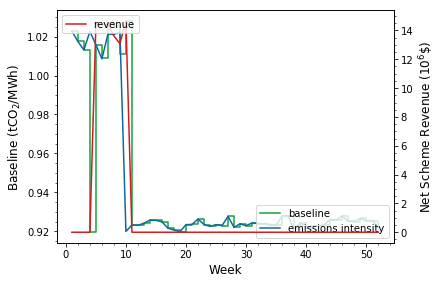

In [83]:
import matplotlib.pyplot as plt

run_id = '1CF6431B'
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)

plt.clf()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = pd.DataFrame.from_dict(week_metrics)['baseline'].plot(drawstyle='steps-post', color='#0ea33d', ax=ax1)
lns2 = pd.DataFrame.from_dict(week_metrics)['rolling_scheme_revenue'].div(1e6).plot(ax=ax2, color='#d31b1b')
lns3 = pd.DataFrame.from_dict(week_metrics)['average_emissions_intensity_regulated_generators'].plot(ax=ax1, color='#0d67a2')
ax1.minorticks_on()
ax1.set_xlabel('Week', fontsize=12)
ax1.set_ylabel('Baseline (tCO$_{2}$/MWh)', fontsize=12)
ax2.set_ylabel('Net Scheme Revenue ($10^{6}$\$)', fontsize=12)
ax2.minorticks_on()

width = 6.5
height = 6.5/1.61
fig.set_size_inches(width, height)
fname = 'revenue_rebalance_no_shocks'

ax1.legend(['baseline', 'emissions intensity'], loc=4)
ax2.legend(['revenue'], loc=2)
# ax2.set_ylim([-1, 1])
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.87, top=0.95)
# fig.savefig(f'output/{fname}.pdf')

plt.show()